# Project Description: Hires Report
This project aims to understand global hiring trends through an ETL (Extract, Transform, Load) process. We collect recruitment data from a CSV File
clean and filter it to focus on candidates with the highest scores in their technical assessments. Then, we store the information in a PostgreSQL
database to facilitate analysis.
Using Python and libraries like Matplotlib and Seaborn, we generate visualizations that help to answer key questions:
Which technologies are most in demand? 
How has hiring evolved in different countries?
Which experience level have the most opportunities?

# Import libraries

In [53]:
import json
import pandas as pd
import os
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Loading Database Credentials

In [54]:
def load_credentials(file_path="credentials.json"):
    try:    
        with open(file_path, "r") as file:
            credentials = json.load(file)
        return credentials
    except Exception as e:
        print(f"Error loading credentials: {e}")
        return None
    
credentials = load_credentials()
if not credentials:
    print("credentials couldn't be loaded. Please check the 'credentials.json'")
    exit()

# Connecting to the PostgreSQL Database

In [55]:
db_username = credentials["db_username"]
db_password = credentials["db_password"]
db_host = credentials["db_host"]
db_port = credentials["db_port"]
database_name = credentials["database_name"]

with open("credentials.json", "r") as file:
    creds = json.load(file)

engine = create_engine(f'postgresql://{db_username}:{db_password}@{db_host}:{db_port}/{database_name}')

# Loading CSV Data

In [56]:
csv_path = r"C:\Users\Danie\OneDrive\Escritorio\Workshop_1\candidates.csv"

def load_csv(file_path):
    try:
        df = pd.read_csv(file_path, sep=';', encoding='utf-8', engine='python',
        on_bad_lines='skip', skipinitialspace=True, dtype=str)
        
        if df.empty:
            print("The csv is empty or couldn't be read correctly")
            return None
        
        df.columns = df.columns.str.strip()
        print("csv loaded succesfully with these columns:")
        print(df.columns.tolist())
        return df
    except Exception as e:
        print("Error reading the csv: {e}")
        return None

# Storing Data in PostgreSQL

In [57]:
def save_to_db(df, engine, table_name):
    try:
        df.to_sql(table_name, engine, if_exists='replace', index=False)
        print(f"Data saved succesfully in the table '{table_name}'")
    except Exception as e:
        print(f"Error storing data in the database: {e}")

# Loading Data from PostgreSQL

In [58]:
def load_from_db(engine, table_name):
    try:
        df = pd.read_sql(f"SELECT * FROM {table_name}", engine)
        print(f"Data loaded from the table '{table_name}'")
        return df
    except Exception as e:
        print(f"Error loading data from the database: {e}")
        return None

# Generación de Visualizaciones

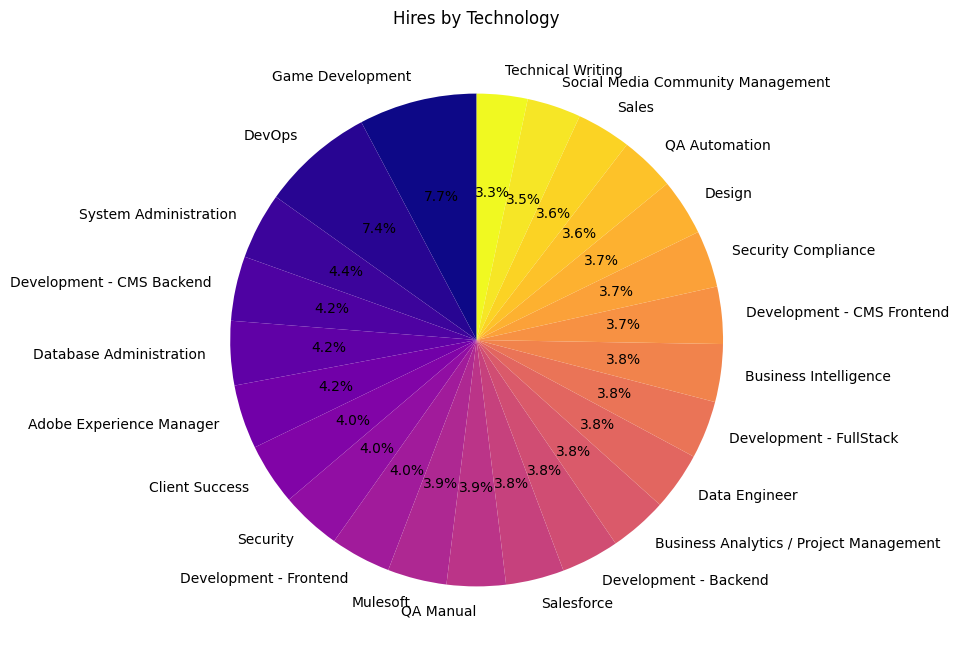

C:\Users\Danie\AppData\Local\Temp\ipykernel_98712\1567363560.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["Application Date"].dt.year.dropna(), palette="viridis")


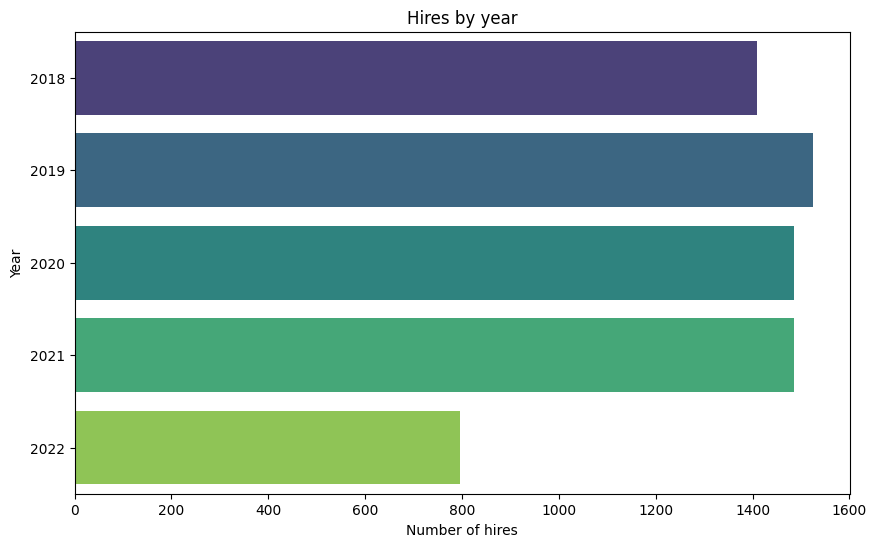

C:\Users\Danie\AppData\Local\Temp\ipykernel_98712\1567363560.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_cleaned["Seniority"], order=df_cleaned["Seniority"].value_counts().index, palette="coolwarm")


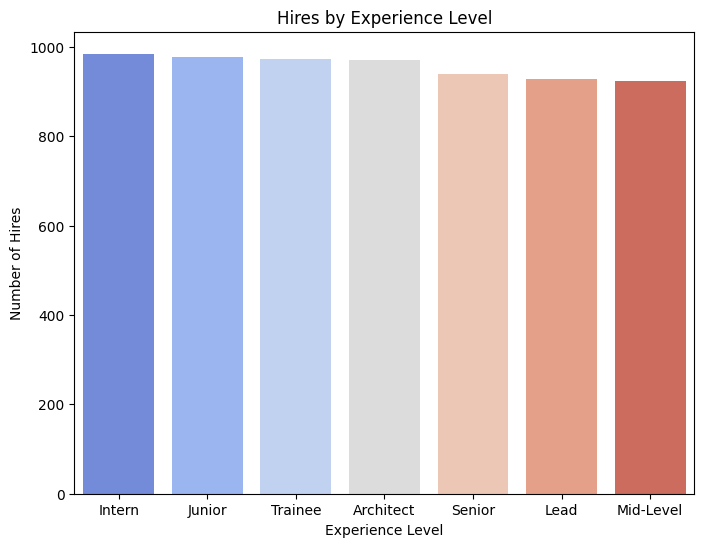

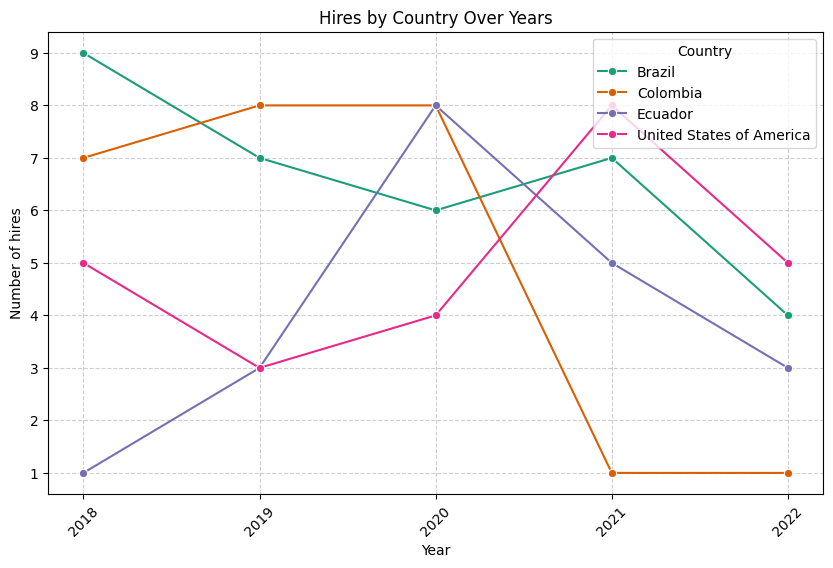

In [59]:
def generate_visualizations(df):
    df["Application Date"] = pd.to_datetime(df["Application Date"], errors="coerce")

    df = df[(df["Code Challenge Score"].astype(float) >= 7) & (df["Technical Interview Score"].astype(float) >= 7)]

    #Chart of hires by Technology
    plt.figure(figsize=(8, 8))
    df["Technology"].value_counts().plot(kind="pie", autopct="%1.1f%%", startangle=90, cmap="plasma")
    plt.title("Hires by Technology")
    plt.ylabel("")
    plt.show()

    #Chart of hires by Year
    plt.figure(figsize=(10, 6))
    sns.countplot(y=df["Application Date"].dt.year.dropna(), palette="viridis")
    plt.title("Hires by year")
    plt.xlabel("Number of hires")
    plt.ylabel("Year")
    plt.show()

    #Chart of hires by experience level
    plt.figure(figsize=(8, 6))
    df_cleaned = df.dropna(subset=["Seniority"])
    sns.countplot(x=df_cleaned["Seniority"], order=df_cleaned["Seniority"].value_counts().index, palette="coolwarm")
    plt.title("Hires by Experience Level")
    plt.xlabel("Experience Level")
    plt.ylabel("Number of Hires")
    plt.show()

    #Charts of hires by country over years
    countries = ["United States of America", "Brazil", "Colombia", "Ecuador"]
    df_filtered = df[df["Country"].isin(countries)]

    df_grouped = df_filtered.groupby(["Country", df_filtered["Application Date"].dt.year])["Country"].count().reset_index(name="num_hires")
    

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data = df_grouped,
        x="Application Date",
        y="num_hires",
        hue="Country",
        marker="o",
        palette="Dark2"
    )
    plt.xticks(df_grouped["Application Date"].unique(), rotation=45)
    plt.title("Hires by Country Over Years")
    plt.xlabel("Year")
    plt.ylabel("Number of hires")
    plt.legend(title="Country", loc="upper right")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
    
generate_visualizations(df)